# Name: Robert
# Student Number: K23050945

In [90]:
import numpy as np
import pandas as pd
import dask.dataframe as dd
import dask.array as da
import dask.bag as db
import pandas as pd
import dask

# The lines code below imports the tick data for GBPUSD from a csv file, transforms the data to remove the unneccessary column containing 0's and
#calulating the price as the midpoint between the bid and the ask, partitions the dataframe into 20 segments for parallel processing and backtesting,
#and verifies the data through a sample and computed statistcs.
forex_df = dd.read_csv("/Users/robertwillfindyou/Downloads/HISTDATA_COM_ASCII_GBPUSD_T202501/DAT_ASCII_GBPUSD_T_202501.csv", header=None, blocksize=None)
forex_df.columns = ['datetime', 'bid', 'ask', 'other']
forex_df = forex_df.drop(columns=['other'])
forex_df = forex_df.repartition(npartitions=20)
forex_df["price"] = (forex_df["bid"] + forex_df["ask"])/2
print(forex_df.head(10))
print()
print("Price Statistics and Description:")
print(forex_df.price.describe().compute())
print()
print(f"The number of partitions of the dataframe: {forex_df.npartitions}")

             datetime      bid      ask     price
0  20250101 170123324  1.25134  1.25240  1.251870
1  20250101 170134857  1.25134  1.25236  1.251850
2  20250101 170138819  1.25138  1.25236  1.251870
3  20250101 170205545  1.25136  1.25236  1.251860
4  20250101 170420239  1.25136  1.25236  1.251860
5  20250101 170432938  1.25136  1.25218  1.251770
6  20250101 170433241  1.25136  1.25209  1.251725
7  20250101 170436259  1.25136  1.25218  1.251770
8  20250101 170436511  1.25136  1.25214  1.251750
9  20250101 170436763  1.25136  1.25209  1.251725

Price Statistics and Description:
count    2.660109e+06
mean     1.234527e+00
std      1.137869e-02
min      1.209965e+00
25%      1.225425e+00
50%      1.236710e+00
75%      1.245315e+00
max      1.257590e+00
Name: price, dtype: float64

The number of partitions of the dataframe: 20


In [91]:
# The function below follows the intrinsic time transformation algorithm in Lecture 8 with a few modification to fit python
def intrinsic_time_transformation(df, delta_up, delta_down):
    # The five lines of code below initialises the variables for tracking the market direction mode, and storing the first tick, extreme price
    #in the current trend, and the last price of the intrinsic price confirmation
    events = []
    mode = None  
    first_tick = True
    S_ext = None  
    S_IE = None 

    # 
    for index, row in df.iterrows():
        S_tick = row['price']

        if first_tick:
            S_ext = S_tick
            S_IE = S_tick
            first_tick = False
            mode = 'up'  # Initial mode assumption
            events.append(0)  # No event for the first tick

        elif mode == 'up': # checks for potential uptrend, else confirms we are in a downtrend
            if S_tick - S_ext >= delta_up:
                mode = 'down'
                S_ext = S_tick
                S_IE = S_tick
                events.append(1)  # Downtrend reversal, thus uptrend starts
            elif S_tick < S_ext:
                S_ext = S_tick
                if S_IE - S_ext >= delta_down:
                    S_IE = S_tick
                    events.append(-2)  # Downtrend confirmation
                else:
                    events.append(0)  # No event
            else:
                events.append(0)  # No event
        elif mode == 'down': # checks for potential downtrend, else confirms we are in a uptrend
            if S_ext - S_tick >= delta_down:
                mode = 'up'
                S_ext = S_tick
                S_IE = S_tick
                events.append(-1)  # uptrend reversal, thus downtrend starts
            elif S_tick > S_ext:
                S_ext = S_tick
                if S_ext - S_IE >= delta_up:
                    S_IE = S_tick
                    events.append(2)  # Uptrend confirmation
                else:
                    events.append(0)  # No event
            else:
                events.append(0)  # No event

    df['event_type'] = events
    return df


### Event Trading Strategy Pseudocode 

Strategy Setup:
    important_events_list = exclude_0s(intrinsic_df)
    last_10_important_events = important_events_list.tail(10)
    grouped_events_count = last_10_important_events.groupby(event_type)

Strategy:
    if event_type is '2' and previous_event is '1' and grouped_events_count.ratio_of(-2) >= 0.5:
        place_buy_order()
    

    if event_type is '-2' and previous_event is '-1' and grouped_events_count.ratio_of(2) >= 0.5:
        place_sell_order()
    

    Rules:
        len(order_placed) <= 1
        and
        exit_at_sl_or_tp()




In [92]:
# The trading strategy below opens a Buy order when the current intrinsic event signal is '2' followed by the '1' intrinsic event signal and
#when the proportion of the latest '-2' intrinsic events has been greater than 50%. The opposite is for a Sell order with the reverse of the
#intrinsic event signals. Also, more than one order cannot be placed at the same time based on this strategy.
def event_trading_strategy(intrinsic_df, profit_target, stop_loss):
    trades = []
    position_open = False
    position_type = None
    entry_price = 0.0
    entry_time = None
    event_count = intrinsic_df[(intrinsic_df.event_type != 0)].tail(10).groupby('event_type').datetime.count()
    event_ratios = event_count/(event_count.sum())
    previous_event = None

    for index, row in intrinsic_df.iterrows():
        timestamp = row['datetime']
        price = row['price']
        event_type = row['event_type']

        if not position_open:
            if -2 in event_ratios.keys():
                if event_type == 2 and previous_event == 1 and event_ratios[-2] >= 0.5:
                    # Open Buy Order
                    position_open = True
                    position_type = 'Buy'
                    entry_price = price
                    entry_time = timestamp
                    print(f"Buy order at {entry_price} on {entry_time}")

            elif 2 in event_ratios.keys():
                if event_type == -2 and previous_event == -1 and event_ratios[2] >= 0.5:
                    # Open Sell Order
                    position_open = True
                    position_type = 'Sell'
                    entry_price = price
                    entry_time = timestamp
                    print(f"Sell order at {entry_price} on {entry_time}")

        else:
            if position_type=='Buy':
                target_price = entry_price * (1 + profit_target)
                stop_price = entry_price * (1 - stop_loss)

                if price >= target_price:
                    # Close Buy Order on Profit if there is a buy order open and the price is greater than the target price
                    position_open = False
                    exit_price = price
                    exit_time = timestamp
                    profit = exit_price - entry_price
                    trades.append((entry_time, entry_price, exit_time, exit_price, profit))
                    position_type=None
                    print(f"Closed Buy order at {exit_price} on {exit_time} for profit of {profit}")
                    
                elif price <= stop_price:
                    # Close Buy Order on a Loss if there is a buy order open and the price is less than the stop loss price
                    position_open = False
                    exit_price = price
                    exit_time = timestamp
                    loss = entry_price - exit_price
                    trades.append((entry_time, entry_price, exit_time, exit_price, -loss))
                    position_type=None
                    print(f"Closed Buy order at {exit_price} on {exit_time} for loss of {loss}")

            elif position_type=='Sell':
                target_price = entry_price * (1 - profit_target)
                stop_price = entry_price * (1 + stop_loss)
                if price <= target_price:
                    # Close Sell Order on Profit if there is a sell order open and the price is less than the target price
                    position_open = False
                    exit_price = price
                    exit_time = timestamp
                    profit = entry_price - exit_price
                    trades.append((entry_time, entry_price, exit_time, exit_price, profit))
                    position_type=None
                    print(f"Closed Sell order at {exit_price} on {exit_time} for profit of {profit}")
                    
                elif price >= stop_price:
                    # Close Sell Order on a Loss if there is a sell order open and the price is greater than the target price
                    position_open = False
                    exit_price = price
                    exit_time = timestamp
                    loss = exit_price - entry_price
                    trades.append((entry_time, entry_price, exit_time, exit_price, -loss))
                    position_type=None
                    print(f"Closed Sell order at {exit_price} on {exit_time} for loss of {loss}")
        
        # The two lines below records the previous intrinsic event to aid the order decision
        if event_type != 0:
            previous_event = event_type

    trades_df = pd.DataFrame(trades, columns=['Entry Time', 'Entry Price', 'Exit Time', 'Exit Price', 'Profit/Loss'])
    trades_df = trades_df.astype({'Entry Time':'string', 'Entry Price':'float64', 'Exit Time':'string', 'Exit Price':'float64', 'Profit/Loss':'float64'})
    return trades_df


In [93]:
# The function below backtests the trading strategy based on the rolling window on each partition of the intrinsic dataframe.
# Each partition is run in parallel using dask.delay to speed up processing time
def backtest_strategy(intrinsic_df, trading_strategy, profit_target, stop_loss, window_size):
    delayed_results = []
    df_partitions = intrinsic_df.npartitions

    for i in range(df_partitions):
        # Get the current and the next partition (if it exists)
        current_partition = intrinsic_df.get_partition(i)
        if i + 1 < df_partitions:
            next_partition = intrinsic_df.get_partition(i + 1)
        else:
            None

        @dask.delayed
        def apply_function(df_pd, pt, sl):
            return trading_strategy(df_pd, pt, sl)

        # Apply the trading strategy to the current partition
        trades_current = apply_function(current_partition.compute(), profit_target, stop_loss)
        delayed_results.append(trades_current)

        # If there's a next partition, consider the overlap for the rolling window
        if next_partition is not None and window_size > 0:
            # Combine a tail of the current partition with the head of the next
            current_tail = current_partition.tail(window_size)
            next_head = next_partition.head(window_size)
            combined_window = pd.concat([current_tail, next_head]).drop_duplicates(subset=['datetime'], keep='first').sort_values(by='datetime').reset_index(drop=True)

            if len(combined_window) > 0:
                trades_combined = apply_function(combined_window, profit_target, stop_loss)
                delayed_results.append(trades_combined)

    # Concatenate all the trade DataFrames
    if delayed_results:
        all_trades_df = dd.from_delayed(delayed_results)
        return all_trades_df
    else:
        return dd.from_pandas(pd.DataFrame(columns=['Entry Time', 'Entry Price', 'Exit Time', 'Exit Price', 'Profit/Loss']), npartitions=1)
    


# Define the thresholds for intrinsic time transformation (and possibly the stop loss and take profit)
delta_up = 0.0001
delta_down = 0.0001

# Apply the intrinsic time transformation to each partition
forex_intrinsic_df = forex_df.map_partitions(intrinsic_time_transformation, delta_up, delta_down)

# Backtest the trading strategy and then print results
trades_record_df = backtest_strategy(forex_intrinsic_df, event_trading_strategy, delta_up, delta_down, 1)
trades_record_pd_df = trades_record_df.compute()
print(trades_record_pd_df)
print()
print(f"Total Profit/Loss: {trades_record_pd_df['Profit/Loss'].sum()}")


Sell order at 1.21519 on 20250113 021111213
Closed Sell order at 1.215315 on 20250113 021115595 for loss of 0.00012499999999993072
Sell order at 1.215115 on 20250113 021126646
Closed Sell order at 1.215245 on 20250113 021207562 for loss of 0.00012999999999996348
Sell order at 1.2150750000000001 on 20250113 021239481
Closed Sell order at 1.215225 on 20250113 021328643 for loss of 0.00014999999999987246
Sell order at 1.2151450000000001 on 20250113 021411327
Closed Sell order at 1.215275 on 20250113 021423710 for loss of 0.00012999999999996348
Sell order at 1.2150599999999998 on 20250113 021439276
Closed Sell order at 1.214935 on 20250113 021504909 for profit of 0.00012499999999970868
Sell order at 1.214955 on 20250113 021648238
Closed Sell order at 1.21483 on 20250113 021702846 for profit of 0.00012499999999993072
Sell order at 1.2148599999999998 on 20250113 021850977
Closed Sell order at 1.214735 on 20250113 022011835 for profit of 0.00012499999999993072
Sell order at 1.214645 on 202501

In [94]:
trades_record_pd_df['Profit/Loss'].describe()

count    541.000000
mean       0.000008
std        0.000140
min       -0.000330
25%       -0.000130
50%        0.000125
75%        0.000130
max        0.000350
Name: Profit/Loss, dtype: float64

<Axes: >

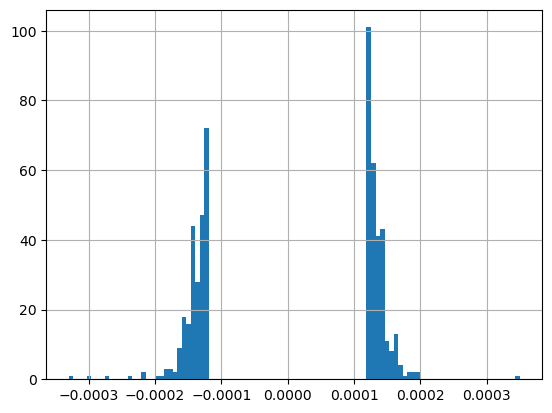

In [95]:
trades_record_pd_df['Profit/Loss'].hist(bins=100)

## Empirical Result Discussion

 Backtesting this specific event-based trading strategy at equal and low delta thresholds (that were also used for setting the take profit and stop loss levels) demonstrates a profit of about 0.004 achieved. Additionally, looking at the histogram distribution of profits/losses of each trade, there is a greater concentration of exit values greater than 0, indicating there were more successful trades than losing trades, and there were no indications of huge wins (outliers) that could have skewed the results. By setting these thresholds low and equal, more trades could be executed, and a statistical edge can be demonstrated with the trading strategy. The trading strategy predicts that after consecutive intrinsic events in one direction, there is likely going to be a trend reversal in the opposite direction as the probability of such gets higher. Therefore, the trading strategy capitalises on placing an order in the opposite direction after there has been both a trend reversal confirmation (1 or -1, respectively) and an immediate confirmation of the same trend (2 or -2, respectively), and these confirmations are done so after a long period of time of the opposite trend direction (ratio of last ten ‘-2’ confirmations has been greater than 50% or the last ten ‘2’ confirmations has been greater than 50%, respectively). 

 Even though the total profit/loss column shows positive gains and more successful trades, tuning the parameters (delta up, delta down, and possibly the window size) would have been great, in order to see ways to maximise profit. However, this poses risks for overfitting based on the sample data, which could lead to bad performance with unforeseen forex data.

 It is also interesting to note how all the trades that occurred based on this data were only sell orders. This verifies how GBPUSD was mostly in an uptrend in January 2025, as sell orders could only be triggered with higher proportions of recent intrinsic events being uptrend confirmations (AKA ‘2’s).